# Initializing the System State

## Overview

### Questions

* How do I place particles in the initial condition?
* What units does HOOMD-blue use?

### Objectives

* Describe the basic properties of the **initial condition**, including particle **position**, **orientation**, **type** and the **periodic box**.
* Briefly describe HOOMD-blue's system of **units**.
* Demonstrate writing a system to a **GSD** file.
* Show how to initialize **Simulation state** from a **GSD** file.

## Boilerplate code

In [1]:
import itertools
import math

import hoomd
import numpy

In [2]:
import os

fn = os.path.join(os.getcwd(), 'lattice.gsd')
![ -e "$fn" ] && rm "$fn"

The `render` function in the next (hidden) cell will render the **initial condition** using **fresnel**.

<div class="alert alert-info">
    This is not intended as a full tutorial on <b>fresnel</b> - see the <a href="https://fresnel.readthedocs.io/">fresnel user documentation</a> if you would like to learn more.
</div>

In [3]:
import warnings

import fresnel
import IPython
import packaging.version

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

FRESNEL_MIN_VERSION = packaging.version.parse("0.13.0")
FRESNEL_MAX_VERSION = packaging.version.parse("0.14.0")


def render(position, orientation, L):
    if ('version' not in dir(fresnel) or packaging.version.parse(
            fresnel.version.version) < FRESNEL_MIN_VERSION
            or packaging.version.parse(
                fresnel.version.version) >= FRESNEL_MAX_VERSION):
        warnings.warn(
            f"Unsupported fresnel version {fresnel.version.version} - expect errors."
        )
    vertices = [
        (-0.5, 0, 0),
        (0.5, 0, 0),
        (0, -0.5, 0),
        (0, 0.5, 0),
        (0, 0, -0.5),
        (0, 0, 0.5),
    ]
    poly_info = fresnel.util.convex_polyhedron_from_vertices(vertices)

    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.ConvexPolyhedron(scene,
                                                 poly_info,
                                                 N=len(position))
    geometry.material = fresnel.material.Material(color=fresnel.color.linear(
        [0.01, 0.74, 0.26]),
                                                  roughness=0.5)
    geometry.position[:] = position[:]
    geometry.orientation[:] = orientation[:]
    geometry.outline_width = 0.01
    box = fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1),
                            color=(0.8, 0.8, 0.8),
                            theta=math.pi),
        fresnel.light.Light(direction=(1, 1, 1),
                            color=(1.1, 1.1, 1.1),
                            theta=math.pi / 3)
    ]
    scene.camera = fresnel.camera.Orthographic(position=(L * 2, L, L * 2),
                                               look_at=(0, 0, 0),
                                               up=(0, 1, 0),
                                               height=L * 1.4 + 1)
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

## Components of the system state

You need to initialize the system **state** before you can run a simulation.
The **initial condition** describes the the **position** and **orientation** of every particle in the system and the **periodic box** at the start of the simulation.

The hard regular octahedra system [self-assembles the the bcc structure](https://doi.org/10.1038/ncomms14038).
Self-assembly is a process where particles will organize themselves into an ordered structure at equilibrium.
Most self-assembly studies run simulations of many thousands of particles for tens of hours.
To keep this tutorial short, it simulations a small number of particles commensurate with the *bcc* structure (`2 * m**3`, where *m* is an integer).

In [4]:
m = 4
N_particles = 2 * m**3

## Placing particles

In hard particle Monte Carlo, valid particle configurations have no overlaps.
The octahedron particle in this tutorial sits inside a sphere of diameter 1, so place particles a little bit further than that apart on a *K*x*K*x*K* simple cubic lattice of width *L*.
The following sections of this tutorial will demonstrate how to randomize this ordered configuration and compress it to a higher density.

In [5]:
spacing = 1.2
K = math.ceil(N_particles**(1 / 3))
L = K * spacing

In HOOMD, particle **positions** must be placed inside a **periodic box**.
Cubic boxes range from -*L*/2 to *L*/2.
Use *itertools* and *numpy* to place the positions on the lattice in this range.

In [6]:
x = numpy.linspace(-L / 2, L / 2, K, endpoint=False)
position = list(itertools.product(x, repeat=3))
print(position[0:4])

[(-3.5999999999999996, -3.5999999999999996, -3.5999999999999996), (-3.5999999999999996, -3.5999999999999996, -2.3999999999999995), (-3.5999999999999996, -3.5999999999999996, -1.1999999999999997), (-3.5999999999999996, -3.5999999999999996, 0.0)]


Filter this list down to *N* particles because `K*K*K >= N_particles` .

In [7]:
position = position[0:N_particles]

You also need to set the **orientation** for each particle.
HOOMD represents orientations with quaternions.
The quaternion (1, 0, 0, 0) represents no rotation. 
Set that for all particles:

In [8]:
orientation = [(1, 0, 0, 0)] * N_particles

Here is what the system looks like now:

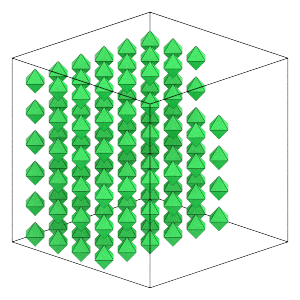

In [9]:
render(position, orientation, L)

## Units

HOOMD-blue does not adopt any particular real system of **units**. 
Instead, HOOMD-blue uses an *internally self-consistent* system of **units** and is compatible with *many systems of units*.
For example: if you select the units of *meter*, *Joule*, and *kilogram* for length, energy and mass then the units of force will be *Newtons* and velocity will be *meters/second*.
A popular system of units for nano-scale systems is *nanometers*, *kilojoules/mol*, and *atomic mass units*.

In HPMC, the *primary* **unit** is that of *length*.
*Mass* exists, but is factored out of the partition function and does not enter into the simulation.
The scale of *energy* is irrelevant in athermal HPMC systems where overlapping energies are infinite and valid configurations have zero potential energy.
However, *energy* does appear implicitly in **derived units** like $[\mathrm{pressure}] = \left(\frac{\mathrm{[energy]}}{\mathrm{[length]}^3}\right)$.
In HPMC, $kT$ is assumed to be 1 *energy*.
You can convert a pressure $P$ in HPMC's units to a non-dimensional value with $P^* = \frac{P\sigma^3}{kT}$ where $\sigma$ is a representative length in your system, such as the particle's diameter or edge length.

## Writing the configuration to the file system

[**GSD**](https://gsd.readthedocs.io/) files store the **periodic box**, particle **positions**, **orientations**,  and other properties of the state.
Use the **GSD** Python package to write this file.

In [10]:
import gsd.hoomd

The **Snapshot** object stores the state of the system.

In [11]:
snapshot = gsd.hoomd.Snapshot()
snapshot.particles.N = N_particles
snapshot.particles.position = position
snapshot.particles.orientation = orientation

Each particle also has a **type**.
In HPMC, each **type** has its own shape parameters.
There is a single **type** in this tutorial, so set a **type id** of 0 for all particles (type ids are 0-indexed):

In [12]:
snapshot.particles.typeid = [0] * N_particles

Every particle **type** needs a **name**.
Names can be any string.
HOOMD-blue uses the type names to match the parameters you specify in **operations** with the type names present in the **state**.
Give the name `'octahedron'` to the type id 0:

In [13]:
snapshot.particles.types = ['octahedron']

**GSD** represents boxes with a 6-element array. Three box lengths *L_x*, *L_y*, *L_z*, and 3 tilt factors. Set equal box lengths 0 tilt factors to define a cubic box.

In [14]:
snapshot.configuration.box = [L, L, L, 0, 0, 0]

Write this snapshot to `lattice.gsd`:

In [15]:
with gsd.hoomd.open(name='lattice.gsd', mode='xb') as f:
    f.append(snapshot)

## Initializing a Simulation

You can use the file to initialize the **Simulation state**.
First, create a **Simulation**:

In [16]:
cpu = hoomd.device.CPU()
sim = hoomd.Simulation(device=cpu)

Then use the `create_state_from_gsd` factory function to read in the GSD file and populate the **state** with the particles and box from the file:

In [17]:
sim.create_state_from_gsd(filename='lattice.gsd')

The next section in this tutorial will show you how to use HPMC to randomize the particle positions and orientations.

[Previous section](02-Performing-Hard-Particle-Monte-Carlo-Simulations.ipynb). [Next section](04-Randomizing-the-System.ipynb).